In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

In [2]:
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from keras.layers.advanced_activations import LeakyReLU, PReLU

Using TensorFlow backend.


In [3]:
# REQUIRED FUNCTION

def shift(df, obj, step=1):
    '''
    '''
    df = pd.concat([df.shift(step), df[obj]], axis=1)
    df = df.dropna()
#     df = df.sample(df.shape[0])
    df = df.values
#     time = df[:, 0]
    X, y = df[:, :-1], df[:, -1]
    return X, y

def scale(train, valid, feature_range=(0, 1)):
    '''
    '''
    scaler = MinMaxScaler(feature_range=feature_range)
    scaler.fit(train)
    
    train_scaled = scaler.transform(train)
    valid_scaled = scaler.transform(valid)
    
    return scaler, train_scaled, valid_scaled

def inverse(scaler, fea, y_pred):
    '''
    '''
    array    = np.c_[fea, y_pred]
    inverted = scaler.inverse_transform(array)
    return inverted[:, -1]

def to_DF(col_name, *args):
    '''
    '''
    assert len(args) != 0, "There are no input data."
    
    df_list = list()
    for arg in args:
        df = pd.DataFrame(data=arg, columns = col_name)
        df_list.append(df)

    return df_list

def MASE(pred, target, orig):
    '''
    '''
    n     = len(target)
    MAE   = np.mean(sum(np.abs(target - pred)))
    MAE_n = np.mean(sum(np.abs(target - orig)))
    e     = MAE / ((n + 1) * MAE_n / n)
    return e

def MAPE(pred, orig):
    '''
    '''
    e = np.mean(np.abs((orig - pred)/orig))
    return e

In [2]:
w4 = pd.read_csv('w4-cali.csv')
w4['date'] = pd.to_datetime(w4['date'])
w = w4.drop(['date'], axis=1)

mtrain, mtest = w[:1400], w[1400:]

In [3]:
w4.describe()

,q_oil,q_gas,q_water,glr,whfp,whft
count,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000
mean,599.474120,296.416179,1082.201869,187.301645,226.211590,60.190800
std,350.070141,179.911243,501.861281,123.573566,28.471952,5.816453
min,8.700000,10.000000,1.258300,5.600000,159.770000,36.330000
25%,237.650000,130.000000,754.540000,84.155000,207.615000,56.325000
50%,652.150000,290.000000,1210.870000,181.020000,221.720000,61.230000
75%,858.820000,455.000000,1485.330000,275.125000,237.295000,64.795000
max,1350.450000,780.000000,1992.690000,670.050000,338.320000,70.870000


## WHFT

In [5]:
scaler, train, test = scale(mtrain, mtest)
cols = w.columns
df = to_DF(cols, train, test)
train, test = df[0], df[1]
print(train.shape, test.shape)

(1400, 6) (207, 6)


In [6]:
vf_whft = test.values[-1].reshape((1, -1))
vf_whft

array([[-0.070309  , -0.02702703,  0.76286356, -0.00930405,  0.50138834,
         0.77562247]])

In [7]:
X_tr1, y_tr1 = shift(train, 'whft', step=1)
X_te1, y_te1 = shift(test, 'whft', step=1)
print(X_tr1.shape, y_tr1.shape, X_te1.shape, y_te1.shape)

(1399, 6) (1399,) (206, 6) (206,)


In [8]:
X_tr1, X_va1, y_tr1, y_va1 = train_test_split(X_tr1, y_tr1, test_size=0.2,shuffle=False)
print(X_tr1.shape, y_tr1.shape, X_va1.shape, y_va1.shape)

(1119, 6) (1119,) (280, 6) (280,)


In [77]:
m1 = Sequential()
m1.add(Dense(7, input_shape=(6, ), activation='relu'))
# m1.add(LeakyReLU(alpha=0.001))
m1.add(Dense(1))
m1.compile(loss='mse', optimizer='adam')

In [78]:
save_best = ModelCheckpoint('save-model-while-train.hdf5',
                            monitor='val_loss',
                            verbose=0, 
                            save_best_only=True,
                            save_weights_only=False,
                            mode='min',
                            period=1)

h1 = m1.fit(X_tr1, y_tr1, 
             epochs=40,
             batch_size=6,
             validation_data=[X_va1, y_va1],
             callbacks=[save_best])

Train on 1119 samples, validate on 280 samples
Epoch 1/40
1119/1119 [==============================] - 1s 1ms/step - loss: 0.2581 - val_loss: 0.1500
Epoch 2/40
1119/1119 [==============================] - 0s 338us/step - loss: 0.0414 - val_loss: 0.1084
Epoch 3/40
1119/1119 [==============================] - 0s 365us/step - loss: 0.0294 - val_loss: 0.0758
Epoch 4/40
1119/1119 [==============================] - 0s 361us/step - loss: 0.0237 - val_loss: 0.0555
Epoch 5/40
1119/1119 [==============================] - 0s 336us/step - loss: 0.0203 - val_loss: 0.0453
Epoch 6/40
1119/1119 [==============================] - 0s 370us/step - loss: 0.0183 - val_loss: 0.0398
Epoch 7/40
1119/1119 [==============================] - 0s 342us/step - loss: 0.0167 - val_loss: 0.0334
Epoch 8/40
1119/1119 [==============================] - 0s 340us/step - loss: 0.0155 - val_loss: 0.0343
Epoch 9/40
1119/1119 [==============================] - 0s 367us/step - loss: 0.0145 - val_loss: 0.0301
Epoch 10/40
1119/11

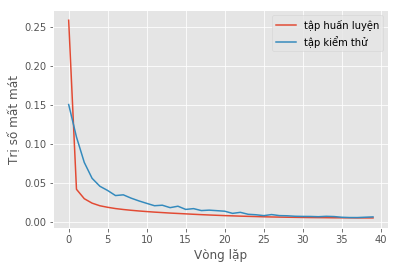

In [79]:
plt.plot(h1.history['loss'], label="tập huấn luyện")
plt.plot(h1.history['val_loss'], label='tập kiểm thử')
plt.xlabel('Vòng lặp')
plt.ylabel('Trị số mất mát')
plt.legend()
plt.show()

In [80]:
w4_whft_loss = pd.DataFrame({'loss': h1.history['loss'],
                              'val_loss': h1.history['val_loss']})
w4_whft_loss.to_csv('w4-whft-loss.csv', index=False)

In [9]:
whft = load_model('save-model-while-train.hdf5')

y_train_pred = whft.predict(X_tr1)
y_valid_pred = whft.predict(X_va1)
y_test_pred = whft.predict(X_te1)

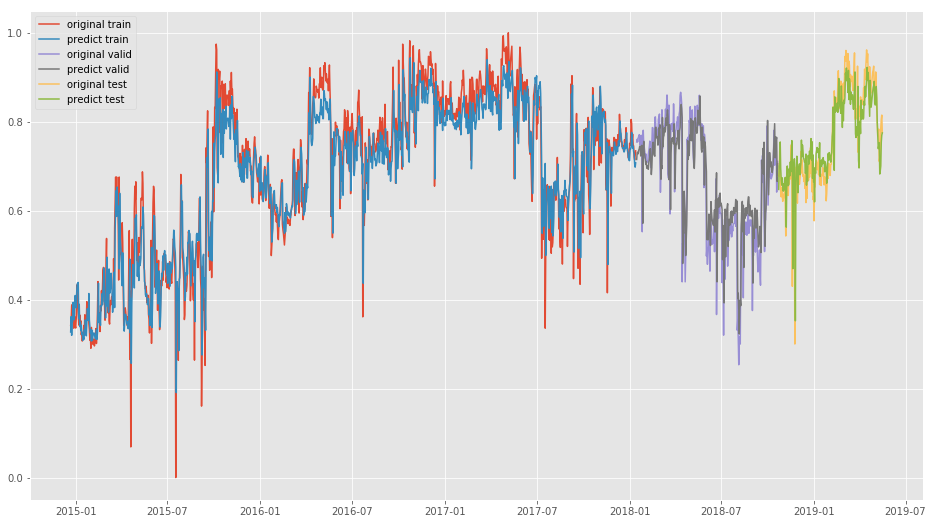

In [82]:
plt.figure(figsize=(16, 9))
plt.plot(w4['date'][:1119], y_tr1, label='original train')
plt.plot(w4['date'][:1119], y_train_pred, label='predict train')
plt.plot(w4['date'][1120:1400], y_va1, label='original valid')
plt.plot(w4['date'][1120:1400], y_valid_pred, label='predict valid')
plt.plot(w4['date'][1401:], y_te1, label='original test')
plt.plot(w4['date'][1401:], y_test_pred, label='predict test')
plt.legend()
plt.show()

In [83]:
print('MSE: {:.4f} | MAPE: {:.4f}'.format(mse(y_test_pred, y_te1), MAPE(y_test_pred, y_te1)))

MSE: 0.0039 | MAPE: 0.1567


In [89]:
# whft.save('whft-loss-0.0039.hdf5')

In [6]:
whft = load_model('whft-loss-0.0039.hdf5')

# y_train_pred = whft.predict(X_tr1)
# y_valid_pred = whft.predict(X_va1)
# y_test_pred = whft.predict(X_te1)

# y_hat = inverse(scaler, X_te1[:, :-1], y_test_pred)
# y_valid_hat = inverse(scaler, X_va1[:, :-1], y_valid_pred)
# y_train_hat = inverse(scaler, X_tr1[:, :-1], y_train_pred)

In [7]:
whft.layers[1].get_weights()[0]

array([[-0.6232653 ],
       [ 0.6465716 ],
       [ 0.50329334],
       [-0.11904979],
       [-0.5759058 ],
       [ 0.73098606],
       [-0.3575255 ]], dtype=float32)

In [11]:
whft.layers[1].get_weights()[1]

array([0.02908818], dtype=float32)

In [57]:
predict_train_set = pd.DataFrame({'date': w4['date'][:1119].values,
                                  'orig': mtrain['whft'][:1119].values,
                                  'pred': y_train_hat})

predict_valid_set = pd.DataFrame({'date': w4['date'][1120:1400].values,
                                 'orig': mtrain['whft'][1120:1400].values,
                                 'pred': y_valid_hat})

predict_test_set = pd.DataFrame({'date': w4['date'][1401:].values,
                                 'orig': mtest['whft'][1:].values,
                                 'pred': y_hat})

predict_train_set.to_csv('whft_train_set.dat', index=False)
predict_valid_set.to_csv('whft_valid_set.dat', index=False)
predict_test_set.to_csv('whft_test_set.dat', index=False)

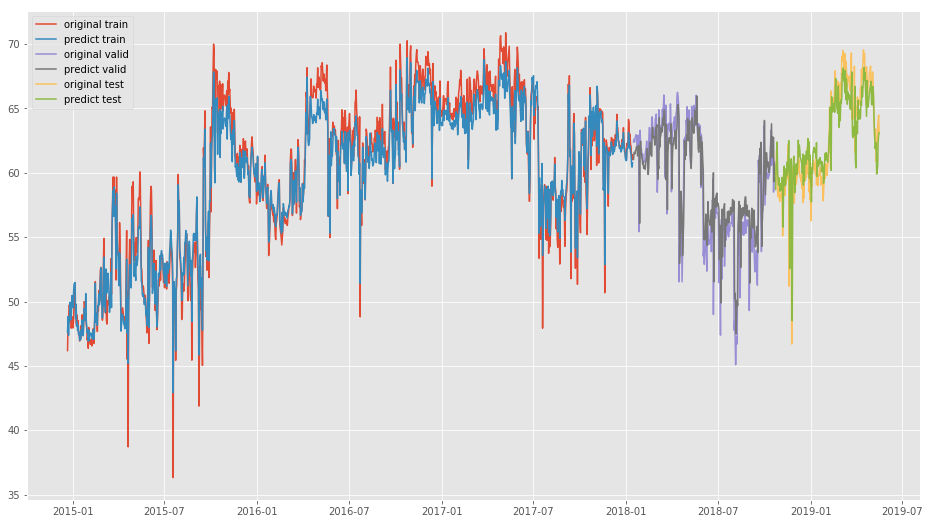

In [26]:
plt.figure(figsize=(16, 9))
plt.plot(w4['date'][:1119], mtrain['whft'][:1119], label='original train')
plt.plot(w4['date'][:1119], y_train_hat, label='predict train')
plt.plot(w4['date'][1120:1400], mtrain['whft'][1120:1400], label='original valid')
plt.plot(w4['date'][1120:1400], y_valid_hat, label='predict valid')
plt.plot(w4['date'][1401:], mtest['whft'][1:], label='original test')
plt.plot(w4['date'][1401:], y_hat, label='predict test')
plt.legend()
plt.show()

In [14]:
m = inverse(scaler, X_te1[:, :-1], y_te1)
print('MSE: {:.4f} | MAPE: {:.4f}'.format(mse(y_hat, m), MAPE(y_hat, m)))

MSE: 4.6760 | MAPE: 0.0249


## WHFP

In [58]:
train1 = pd.concat([mtrain.drop(['whfp'], axis=1), mtrain['whfp']], axis=1)
test1 = pd.concat([mtest.drop(['whfp'], axis=1), mtest['whfp']], axis=1)

In [59]:
scaler, train, test = scale(train1, test1)
cols = train1.columns
df = to_DF(cols, train, test)
train, test = df[0], df[1]
print(train.shape, test.shape)

(1400, 6) (207, 6)


In [60]:
vf_whfp = test.values[-1].reshape((1, -1))
vf_whfp

array([[-0.070309  , -0.02702703,  0.76286356, -0.00930405,  0.77562247,
         0.50138834]])

In [61]:
X_tr2, y_tr2 = shift(train, 'whfp', step=1)
X_te2, y_te2 = shift(test, 'whfp', step=1)
print(X_tr2.shape, y_tr2.shape, X_te2.shape, y_te2.shape)

(1399, 6) (1399,) (206, 6) (206,)


In [62]:
X_tr2, X_va2, y_tr2, y_va2 = train_test_split(X_tr2, y_tr2, test_size=0.2,shuffle=False)
print(X_tr2.shape, y_tr2.shape, X_va2.shape, y_va2.shape)

(1119, 6) (1119,) (280, 6) (280,)


In [180]:
m2 = Sequential()
m2.add(Dense(7, input_shape=(6, ), activation='relu'))
# m2.add(LeakyReLU(alpha=0.001))
m2.add(Dense(1))
m2.compile(loss='mse', optimizer='adam')

In [181]:
save_best = ModelCheckpoint('save-model-while-train.hdf5',
                            monitor='val_loss',
                            verbose=0, 
                            save_best_only=True,
                            save_weights_only=False,
                            mode='min',
                            period=1)

h2 = m2.fit(X_tr2, y_tr2, 
             epochs=50,
             batch_size=6,
             validation_data=[X_va2, y_va2],
             callbacks=[save_best])

Train on 1119 samples, validate on 280 samples
Epoch 1/50
1119/1119 [==============================] - 2s 1ms/step - loss: 0.1320 - val_loss: 0.0087
Epoch 2/50
1119/1119 [==============================] - 0s 371us/step - loss: 0.0262 - val_loss: 0.0131
Epoch 3/50
1119/1119 [==============================] - 0s 411us/step - loss: 0.0127 - val_loss: 0.0077
Epoch 4/50
1119/1119 [==============================] - 0s 378us/step - loss: 0.0084 - val_loss: 0.0048
Epoch 5/50
1119/1119 [==============================] - 0s 376us/step - loss: 0.0074 - val_loss: 0.0044
Epoch 6/50
1119/1119 [==============================] - 0s 383us/step - loss: 0.0070 - val_loss: 0.0042
Epoch 7/50
1119/1119 [==============================] - 0s 379us/step - loss: 0.0069 - val_loss: 0.0043
Epoch 8/50
1119/1119 [==============================] - 0s 373us/step - loss: 0.0068 - val_loss: 0.0042
Epoch 9/50
1119/1119 [==============================] - 0s 388us/step - loss: 0.0068 - val_loss: 0.0043
Epoch 10/50
1119/11

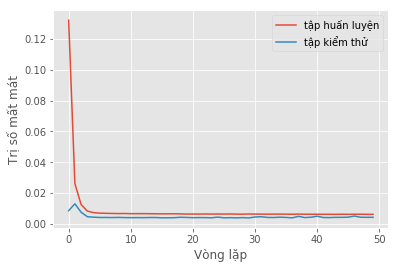

In [182]:
plt.plot(h2.history['loss'], label="tập huấn luyện")
plt.plot(h2.history['val_loss'], label='tập kiểm thử')
plt.xlabel('Vòng lặp')
plt.ylabel('Trị số mất mát')
plt.legend()
plt.show()

In [183]:
w4_whfp_loss = pd.DataFrame({'loss': h2.history['loss'],
                              'val_loss': h2.history['val_loss']})
w4_whfp_loss.to_csv('w4-whfp-loss.csv', index=False)

In [184]:
whfp = load_model('save-model-while-train.hdf5')

y_train_pred = whfp.predict(X_tr2)
y_valid_pred = whft.predict(X_va2)
y_test_pred = whfp.predict(X_te2)

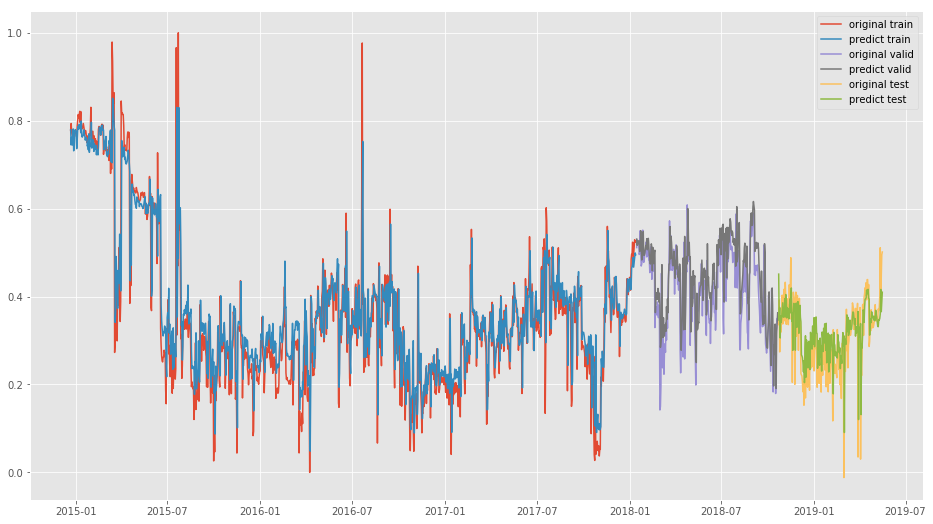

In [185]:
plt.figure(figsize=(16, 9))
plt.plot(w4['date'][:1119], y_tr2, label='original train')
plt.plot(w4['date'][:1119], y_train_pred, label='predict train')
plt.plot(w4['date'][1120:1400], y_va2, label='original valid')
plt.plot(w4['date'][1120:1400], y_valid_pred, label='predict valid')
plt.plot(w4['date'][1401:], y_te2, label='original test')
plt.plot(w4['date'][1401:], y_test_pred, label='predict test')
plt.legend()
plt.show()

In [186]:
print('MSE: {:.4f} | MAPE: {:.4f}'.format(mse(y_test_pred, y_te2), MAPE(y_test_pred, y_te2)))

MSE: 0.0053 | MAPE: 0.4935


In [191]:
# whfp.save('whfp-loss-0.0053.hdf5')

In [13]:
whfp = load_model('whfp-loss-0.0053.hdf5')
whfp.layers[1].get_weights()[1]

array([0.08196388], dtype=float32)

In [63]:
whfp = load_model('whfp-loss-0.0053.hdf5')

y_train_pred = whfp.predict(X_tr2)
y_valid_pred = whfp.predict(X_va2)
y_test_pred = whfp.predict(X_te2)

y_hat = inverse(scaler, X_te2[:, :-1], y_test_pred)
y_valid_hat = inverse(scaler, X_va2[:, :-1], y_valid_pred)
y_train_hat = inverse(scaler, X_tr2[:, :-1], y_train_pred)

In [64]:
predict_train_set = pd.DataFrame({'date': w4['date'][:1119].values,
                                  'orig': mtrain['whfp'][:1119].values,
                                  'pred': y_train_hat})

predict_valid_set = pd.DataFrame({'date': w4['date'][1120:1400].values,
                                 'orig': mtrain['whfp'][1120:1400].values,
                                 'pred': y_valid_hat})

predict_test_set = pd.DataFrame({'date': w4['date'][1401:].values,
                                 'orig': mtest['whfp'][1:].values,
                                 'pred': y_hat})

predict_train_set.to_csv('whfp_train_set.dat', index=False)
predict_valid_set.to_csv('whfp_valid_set.dat', index=False)
predict_test_set.to_csv('whfp_test_set.dat', index=False)

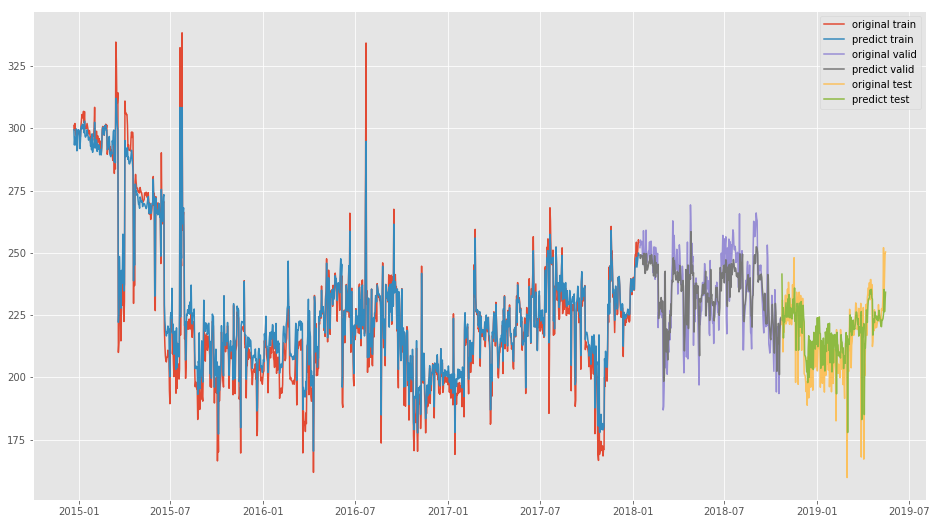

In [34]:
plt.figure(figsize=(16, 9))
plt.plot(w4['date'][:1119], mtrain['whfp'][:1119], label='original train')
plt.plot(w4['date'][:1119], y_train_hat, label='predict train')
plt.plot(w4['date'][1120:1400], mtrain['whfp'][1120:1400], label='original valid')
plt.plot(w4['date'][1120:1400], y_valid_hat, label='predict valid')
plt.plot(w4['date'][1401:], mtest['whfp'][1:], label='original test')
plt.plot(w4['date'][1401:], y_hat, label='predict test')
plt.legend()
plt.show()

In [23]:
m = test1['whfp'][:-1].values
print('MSE: {:.4f} | MAPE: {:.4f}'.format(mse(y_hat, m), MAPE(y_hat, m)))

MSE: 41.2833 | MAPE: 0.0257


## WATER RATE

In [65]:
train2 = pd.concat([mtrain.drop(['q_water'], axis=1), mtrain['q_water']], axis=1)
test2 = pd.concat([mtest.drop(['q_water'], axis=1), mtest['q_water']], axis=1)

In [66]:
scaler, train, test = scale(train2, test2)
cols = train2.columns
df = to_DF(cols, train, test)
train, test = df[0], df[1]
print(train.shape, test.shape)

(1400, 6) (207, 6)


In [67]:
vf_water_rate = test.values[-1].reshape((1, -1))
vf_water_rate

array([[-0.070309  , -0.02702703, -0.00930405,  0.50138834,  0.77562247,
         0.76286356]])

In [68]:
X_tr3, y_tr3 = shift(train, 'q_water', step=1)
X_te3, y_te3 = shift(test, 'q_water', step=1)
print(X_tr3.shape, y_tr3.shape, X_te3.shape, y_te3.shape)

(1399, 6) (1399,) (206, 6) (206,)


In [69]:
X_tr3, X_va3, y_tr3, y_va3 = train_test_split(X_tr3, y_tr3, test_size=0.2,shuffle=False)
print(X_tr3.shape, y_tr3.shape, X_va3.shape, y_va3.shape)

(1119, 6) (1119,) (280, 6) (280,)


In [108]:
m3 = Sequential()
m3.add(Dense(7, input_shape=(6, ), activation='relu'))
# m3.add(LeakyReLU(alpha=0.001))
m3.add(Dense(1))
m3.compile(loss='mse', optimizer='adam')

In [109]:
save_best = ModelCheckpoint('save-model-while-train.hdf5',
                            monitor='val_loss',
                            verbose=0, 
                            save_best_only=True,
                            save_weights_only=False,
                            mode='min',
                            period=1)

h3 = m3.fit(X_tr3, y_tr3, 
             epochs=60,
             batch_size=8,
             validation_data=[X_va3, y_va3],
             callbacks=[save_best])

Train on 1119 samples, validate on 280 samples
Epoch 1/60
1119/1119 [==============================] - 2s 1ms/step - loss: 0.1025 - val_loss: 0.0712
Epoch 2/60
1119/1119 [==============================] - 0s 330us/step - loss: 0.0358 - val_loss: 0.0237
Epoch 3/60
1119/1119 [==============================] - 0s 279us/step - loss: 0.0122 - val_loss: 0.0097
Epoch 4/60
1119/1119 [==============================] - 0s 288us/step - loss: 0.0050 - val_loss: 0.0039
Epoch 5/60
1119/1119 [==============================] - 0s 286us/step - loss: 0.0028 - val_loss: 0.0028
Epoch 6/60
1119/1119 [==============================] - 0s 285us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 7/60
1119/1119 [==============================] - 0s 319us/step - loss: 0.0019 - val_loss: 0.0022
Epoch 8/60
1119/1119 [==============================] - 0s 287us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 9/60
1119/1119 [==============================] - 0s 286us/step - loss: 0.0017 - val_loss: 0.0018
Epoch 10/60
1119/11

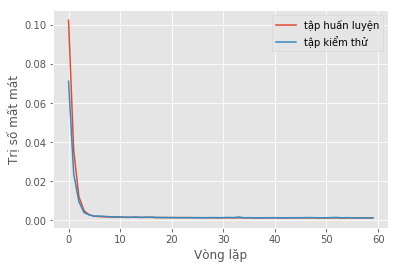

In [110]:
plt.plot(h3.history['loss'], label="tập huấn luyện")
plt.plot(h3.history['val_loss'], label='tập kiểm thử')
plt.xlabel('Vòng lặp')
plt.ylabel('Trị số mất mát')
plt.legend()
plt.show()

In [111]:
w4_water_rate_loss = pd.DataFrame({'loss': h3.history['loss'],
                              'val_loss': h3.history['val_loss']})
w4_water_rate_loss.to_csv('w4-water-rate-loss.csv', index=False)

In [112]:
water = load_model('save-model-while-train.hdf5')

y_train_pred = water.predict(X_tr3)
y_valid_pred = water.predict(X_va3)
y_test_pred = water.predict(X_te3)

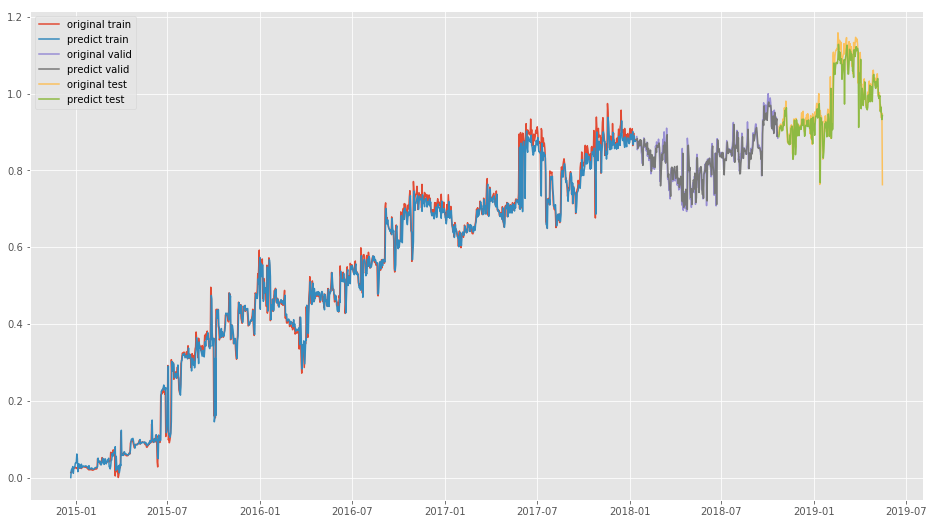

In [113]:
plt.figure(figsize=(16, 9))
plt.plot(w4['date'][:1119], y_tr3, label='original train')
plt.plot(w4['date'][:1119], y_train_pred, label='predict train')
plt.plot(w4['date'][1120:1400], y_va3, label='original valid')
plt.plot(w4['date'][1120:1400], y_valid_pred, label='predict valid')
plt.plot(w4['date'][1401:], y_te3, label='original test')
plt.plot(w4['date'][1401:], y_test_pred, label='predict test')
plt.legend()
plt.show()

In [114]:
print('MSE: {:.4f} | MAPE: {:.4f}'.format(mse(y_test_pred, y_te3), MAPE(y_test_pred, y_te3)))

MSE: 0.0019 | MAPE: 0.0961


In [120]:
# water.save('water-rate-loss-0.0019.hdf5')

In [15]:
water = load_model('water-rate-loss-0.0019.hdf5')
water.layers[1].get_weights()[0]

array([[-0.6776867 ],
       [-0.18536897],
       [ 0.12809412],
       [ 0.07551043],
       [ 0.5750804 ],
       [ 0.516846  ],
       [-0.11138934]], dtype=float32)

In [70]:
water = load_model('water-rate-loss-0.0019.hdf5')

y_train_pred = water.predict(X_tr3)
y_valid_pred = water.predict(X_va3)
y_test_pred = water.predict(X_te3)

y_hat = inverse(scaler, X_te3[:, :-1], y_test_pred)
y_valid_hat = inverse(scaler, X_va3[:, :-1], y_valid_pred)
y_train_hat = inverse(scaler, X_tr3[:, :-1], y_train_pred)

In [71]:
predict_train_set = pd.DataFrame({'date': w4['date'][:1119].values,
                                  'orig': mtrain['q_water'][:1119].values,
                                  'pred': y_train_hat})

predict_valid_set = pd.DataFrame({'date': w4['date'][1120:1400].values,
                                 'orig': mtrain['q_water'][1120:1400].values,
                                 'pred': y_valid_hat})

predict_test_set = pd.DataFrame({'date': w4['date'][1401:].values,
                                 'orig': mtest['q_water'][1:].values,
                                 'pred': y_hat})

predict_train_set.to_csv('water_train_set.dat', index=False)
predict_valid_set.to_csv('water_valid_set.dat', index=False)
predict_test_set.to_csv('water_test_set.dat', index=False)

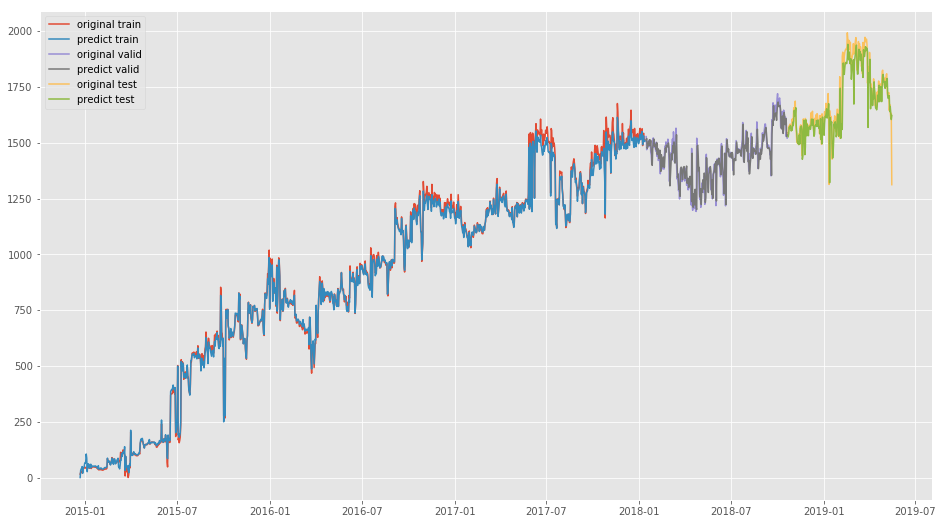

In [43]:
plt.figure(figsize=(16, 9))
plt.plot(w4['date'][:1119], mtrain['q_water'][:1119], label='original train')
plt.plot(w4['date'][:1119], y_train_hat, label='predict train')
plt.plot(w4['date'][1120:1400], mtrain['q_water'][1120:1400], label='original valid')
plt.plot(w4['date'][1120:1400], y_valid_hat, label='predict valid')
plt.plot(w4['date'][1401:], mtest['q_water'][1:], label='original test')
plt.plot(w4['date'][1401:], y_hat, label='predict test')
plt.legend()
plt.show()

In [118]:
m = test2['q_water'][:-1].values
print('MSE: {:.4f} | MAPE: {:.4f}'.format(mse(y_hat, m), MAPE(y_hat, m)))

MSE: 1571.6932 | MAPE: 0.0136


In [119]:
np.sqrt(mse(y_hat, m))

39.64458660487787

## OIL RATE

In [28]:
train3 = pd.concat([mtrain.drop(['q_oil'], axis=1), mtrain['q_oil']], axis=1)
test3 = pd.concat([mtest.drop(['q_oil'], axis=1), mtest['q_oil']], axis=1)

In [29]:
scaler, train, test = scale(train3, test3)
cols = train3.columns
df = to_DF(cols, train, test)
train, test = df[0], df[1]
print(train.shape, test.shape)

(1400, 6) (207, 6)


In [30]:
X_tr4, y_tr4 = shift(train, 'q_oil', step=1)
X_te4, y_te4 = shift(test, 'q_oil', step=1)
print(X_tr4.shape, y_tr4.shape, X_te4.shape, y_te4.shape)

(1399, 6) (1399,) (206, 6) (206,)


In [31]:
X_tr4, X_va4, y_tr4, y_va4 = train_test_split(X_tr4, y_tr4, test_size=0.2,shuffle=False)
print(X_tr4.shape, y_tr4.shape, X_va4.shape, y_va4.shape)

(1119, 6) (1119,) (280, 6) (280,)


In [32]:
vf_oil = test.values[-1].reshape((1, -1))
vf_oil

array([[-0.02702703,  0.76286356, -0.00930405,  0.50138834,  0.77562247,
        -0.070309  ]])

In [46]:
m4 = Sequential()
m4.add(Dense(7, input_shape=(6, ), activation='relu'))
# m4.add(LeakyReLU(alpha=0.001))
m4.add(Dense(1))
m4.compile(loss='mse', optimizer='adam')

In [47]:
save_best = ModelCheckpoint('save-model-while-train.hdf5',
                            monitor='val_loss',
                            verbose=0, 
                            save_best_only=True,
                            save_weights_only=False,
                            mode='min',
                            period=1)

h4 = m4.fit(X_tr4, y_tr4, 
             epochs=40,
             batch_size=8,
             validation_data=[X_va4, y_va4],
             callbacks=[save_best])

Train on 1119 samples, validate on 280 samples
Epoch 1/40
1119/1119 [==============================] - 1s 1ms/step - loss: 0.0547 - val_loss: 0.1696
Epoch 2/40
1119/1119 [==============================] - 0s 284us/step - loss: 0.0251 - val_loss: 0.1128
Epoch 3/40
1119/1119 [==============================] - 0s 291us/step - loss: 0.0143 - val_loss: 0.0533
Epoch 4/40
1119/1119 [==============================] - 0s 298us/step - loss: 0.0092 - val_loss: 0.0398
Epoch 5/40
1119/1119 [==============================] - 0s 287us/step - loss: 0.0061 - val_loss: 0.0272
Epoch 6/40
1119/1119 [==============================] - 0s 290us/step - loss: 0.0043 - val_loss: 0.0187
Epoch 7/40
1119/1119 [==============================] - 0s 291us/step - loss: 0.0033 - val_loss: 0.0098
Epoch 8/40
1119/1119 [==============================] - 0s 296us/step - loss: 0.0026 - val_loss: 0.0090
Epoch 9/40
1119/1119 [==============================] - 0s 286us/step - loss: 0.0023 - val_loss: 0.0088
Epoch 10/40
1119/11

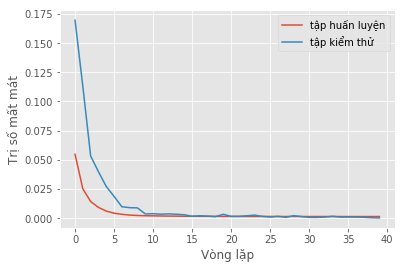

In [59]:
plt.plot(h4.history['loss'], label="tập huấn luyện")
plt.plot(h4.history['val_loss'], label='tập kiểm thử')
plt.xlabel('Vòng lặp')
plt.ylabel('Trị số mất mát')
plt.legend()
plt.show()

In [60]:
w4_oil_rate_loss = pd.DataFrame({'loss': h4.history['loss'],
                                 'val_loss': h4.history['val_loss']})
w4_oil_rate_loss.to_csv('w4-oil-rate-loss.csv', index=False)

In [48]:
oil = load_model('save-model-while-train.hdf5')

y_train_pred = oil.predict(X_tr4)
y_valid_pred = oil.predict(X_va4)
y_test_pred = oil.predict(X_te4)

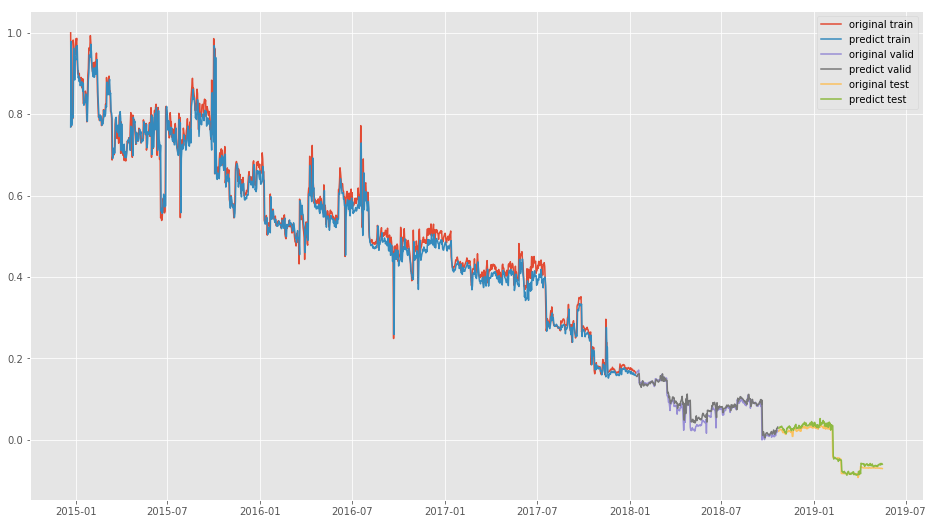

In [49]:
plt.figure(figsize=(16, 9))
plt.plot(w4['date'][:1119], y_tr4, label='original train')
plt.plot(w4['date'][:1119], y_train_pred, label='predict train')
plt.plot(w4['date'][1120:1400], y_va4, label='original valid')
plt.plot(w4['date'][1120:1400], y_valid_pred, label='predict valid')
plt.plot(w4['date'][1401:], y_te4, label='original test')
plt.plot(w4['date'][1401:], y_test_pred, label='predict test')
plt.legend()
plt.show()

In [51]:
print('MSE: {:.4f} | MAPE: {:.4f}'.format(mse(y_test_pred, y_te4), MAPE(y_test_pred, y_te4)))

MSE: 0.0001 | MAPE: 1.4531


In [53]:
# oil.save('oil-rate-loss-0.0001.hdf5')

In [54]:
oil = load_model('oil-rate-loss-0.0001.hdf5')

In [61]:
oil.layers[1].get_weights()

[array([[-0.07596113],
        [-0.5995857 ],
        [ 0.66813934],
        [-0.26451865],
        [ 0.50353277],
        [-0.49887973],
        [-0.05269909]], dtype=float32), array([0.05758463], dtype=float32)]

In [55]:
# oil = load_model('oil-rate-loss-0.0005.hdf5')

y_train_pred = oil.predict(X_tr4)
y_valid_pred = oil.predict(X_va4)
y_test_pred = oil.predict(X_te4)

y_hat = inverse(scaler, X_te4[:, :-1], y_test_pred)
y_valid_hat = inverse(scaler, X_va4[:, :-1], y_valid_pred)
y_train_hat = inverse(scaler, X_tr4[:, :-1], y_train_pred)

In [56]:
predict_train_set = pd.DataFrame({'date': w4['date'][:1119].values,
                                  'orig': mtrain['q_oil'][:1119].values,
                                  'pred': y_train_hat})

predict_valid_set = pd.DataFrame({'date': w4['date'][1120:1400].values,
                                 'orig': mtrain['q_oil'][1120:1400].values,
                                 'pred': y_valid_hat})

predict_test_set = pd.DataFrame({'date': w4['date'][1401:].values,
                                 'orig': mtest['q_oil'][1:].values,
                                 'pred': y_hat})

predict_train_set.to_csv('oil_train_set.dat', index=False)
predict_valid_set.to_csv('oil_valid_set.dat', index=False)
predict_test_set.to_csv('oil_test_set.dat', index=False)

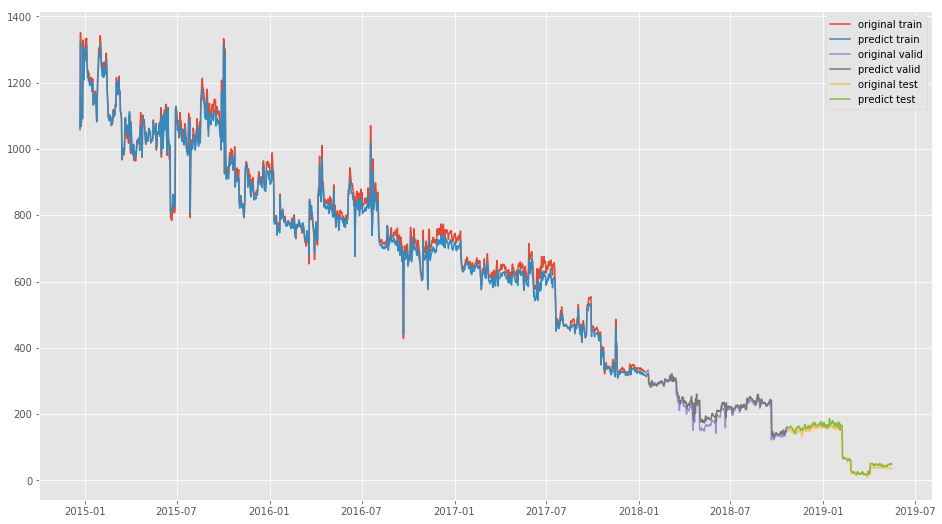

In [57]:
plt.figure(figsize=(16, 9))
plt.plot(w4['date'][:1119], mtrain['q_oil'][:1119], label='original train')
plt.plot(w4['date'][:1119], y_train_hat, label='predict train')
plt.plot(w4['date'][1120:1400], mtrain['q_oil'][1120:1400], label='original valid')
plt.plot(w4['date'][1120:1400], y_valid_hat, label='predict valid')
plt.plot(w4['date'][1401:], mtest['q_oil'][1:], label='original test')
plt.plot(w4['date'][1401:], y_hat, label='predict test')
plt.legend()
plt.show()

In [58]:
m = test3['q_oil'][:-1].values
print('MSE: {:.4f} | MAPE: {:.4f}'.format(mse(y_hat, m), MAPE(y_hat, m)))

MSE: 74.6872 | MAPE: 0.1239


## PREDICT

In [10]:
whft = load_model('whft-loss-0.0041.hdf5')
pred = whft.predict(vf_whft)
whft_for_future = inverse(scaler, vf_whft[:, :-1], pred)

In [11]:
whft_for_future

array([62.1934463])

In [24]:
whfp = load_model('whfp-loss-0.0052.hdf5')
pred = whfp.predict(vf_whfp)
whfp_for_future = inverse(scaler, vf_whfp[:, :-1], pred)

In [25]:
whfp_for_future

array([223.19250999])

In [29]:
water = load_model('water-rate-loss-0.0016.hdf5')
pred = water.predict(vf_water_rate)
water_rate_for_future = inverse(scaler, vf_water_rate[:, :-1], pred)

In [30]:
water_rate_for_future

array([1359.15742709])

In [61]:
oil = load_model('oil-rate-loss-0.0003.hdf5')
pred = oil.predict(vf_oil)
oil_rate_future = inverse(scaler, vf_oil[:, :-1], pred)

In [62]:
oil_rate_future

array([40.33944348])